# Statsmodels buat ngecek regresi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',False)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [4]:
df = pd.read_csv('data_bersih_ver3.csv')
df = df[df['tipe']=='Rumah']
df = df.drop(['Unnamed: 0','tipe'], axis = 1)
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12266 entries, 0 to 13495
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    12266 non-null  int64  
 1   kamar_tidur    12266 non-null  int64  
 2   luas_bangunan  12266 non-null  float64
 3   luas_tanah     12266 non-null  float64
 4   harga          12266 non-null  float64
 5   kecamatan      12266 non-null  object 
 6   garasi         12266 non-null  bool   
 7   kolam_renang   12266 non-null  bool   
 8   taman          12266 non-null  bool   
 9   gym            12266 non-null  bool   
 10  listrik        12266 non-null  float64
 11  jumlah_lantai  12266 non-null  int64  
dtypes: bool(4), float64(4), int64(3), object(1)
memory usage: 910.4+ KB


In [5]:
from feature_engine.outliers import OutlierTrimmer as OT

In [6]:
trimer =capper = OT(
    capping_method ='iqr', 
    tail = 'right', 
    fold = 3, 
    variables = ['harga']
)
trimer.fit(df)

OutlierTrimmer(capping_method='iqr', variables=['harga'])

In [7]:
df = trimer.transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11384 entries, 0 to 13495
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    11384 non-null  int64  
 1   kamar_tidur    11384 non-null  int64  
 2   luas_bangunan  11384 non-null  float64
 3   luas_tanah     11384 non-null  float64
 4   harga          11384 non-null  float64
 5   kecamatan      11384 non-null  object 
 6   garasi         11384 non-null  bool   
 7   kolam_renang   11384 non-null  bool   
 8   taman          11384 non-null  bool   
 9   gym            11384 non-null  bool   
 10  listrik        11384 non-null  float64
 11  jumlah_lantai  11384 non-null  int64  
dtypes: bool(4), float64(4), int64(3), object(1)
memory usage: 844.9+ KB


In [8]:
df['kecamatan'].nunique()

42

In [9]:
num = [i for i in df.columns if df[i].dtypes in ['int64', 'float']]
cat = [i for i in df.columns if df[i].dtypes in ['O', 'bool']]

In [10]:
df[cat] = df[cat].astype('O')

In [11]:
from feature_engine.encoding import OrdinalEncoder as OE

In [12]:
oe = OE(variables = [i for i in cat])
oe.fit(df,df['harga'])

OrdinalEncoder(variables=['kecamatan', 'garasi', 'kolam_renang', 'taman',
                          'gym'])

In [13]:
x = oe.transform(df)

In [14]:
from sklearn.preprocessing import StandardScaler as ss

In [15]:
x_scale = ss()
x_scale.fit(x.drop('harga',axis = 1))
y_scale = ss()
y_scale.fit(x[['harga']])

StandardScaler()

In [16]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11384 entries, 0 to 13495
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    11384 non-null  int64  
 1   kamar_tidur    11384 non-null  int64  
 2   luas_bangunan  11384 non-null  float64
 3   luas_tanah     11384 non-null  float64
 4   harga          11384 non-null  float64
 5   kecamatan      11384 non-null  int64  
 6   garasi         11384 non-null  int64  
 7   kolam_renang   11384 non-null  int64  
 8   taman          11384 non-null  int64  
 9   gym            11384 non-null  int64  
 10  listrik        11384 non-null  float64
 11  jumlah_lantai  11384 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 1.1 MB


In [17]:
import statsmodels.api as sm

In [18]:
x = x_scale.transform(x.drop(['harga'],axis = 1))
x = pd.DataFrame(x)
x.columns = df.drop('harga', axis = 1).columns

y = y_scale.transform(df[['harga']])
y = pd.DataFrame(y)
y.columns = ['harga']
initial_data = pd.concat([x,y],axis = 1)
x = sm.add_constant(x)

In [19]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     2001.
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        11:27:49   Log-Likelihood:                -10023.
No. Observations:               11384   AIC:                         2.007e+04
Df Residuals:                   11372   BIC:                         2.016e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.714e-17      0.005  -1.78e-14      1.000      -0.011       0.011
kamar_mandi       0.0725      0.008      8.858      0.000       0.056       0.089
kamar_tidur       0.0149      0.008      1.940      0.052      -0.000       0.030
luas_bangunan     0.3794      0.009     43.226      0.000       0.362       0.397
luas_tanah        0.2769      0.008     34.503      0.000       0.261       0.293
kecamatan         0.2781      0.006     47.289      0.000       0.267       0.290
garasi           -0.0291      0.006     -5.111      0.000      -0.040      -0.018
kolam_renang      0.1036      0.006     17.712      0.000       0.092       0.115
taman             0.0210      0.006      3.783      0.000       0.010       0.032
gym              -0.0129      0.006     -2.315      0.021      -0.024      -0.002
listrik           0.0184      0.006      3.291      0.001       0.007       0.029
jumlah_lantai    -0.0086      0.006     -1.461      0.144      -0.020       0.003
==============================================================================
Omnibus:                    12101.181   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14039200.084
Skew:                          -4.371   Prob(JB):                         0.00
Kurtosis:                     174.818   Cond. No.                         3.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
pd.DataFrame(model.params).reset_index().sort_values(by = 0, ascending = False)

,index,0
3,luas_bangunan,3.794493e-01
5,kecamatan,2.780833e-01
4,luas_tanah,2.769060e-01
7,kolam_renang,1.035905e-01
1,kamar_mandi,7.254070e-02
8,taman,2.102787e-02
10,listrik,1.844533e-02
2,kamar_tidur,1.488850e-02
0,const,-9.714451e-17
11,jumlah_lantai,-8.623381e-03


In [21]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [22]:
y_pred = model.predict(x)
sqrt(mse(y_pred, y))

0.583626685143854

In [23]:
from scipy import stats

In [24]:
for k in cat+num:
    if df[k].nunique() <100:
        print("="*45,f' {k} ',"="*45)
        var = [i for i in df[k].unique()]
        pair = {}
        udah = []
        for i in var:
            for j in var:
                if (j not in udah) & (i != j):
                    ttest = stats.ttest_ind(a = df[df[k] == i]['harga'],
                                            b = df[df[k] == j]['harga'])
                    p_value = ttest.pvalue
                    pair[f'{i} - {j}'] = p_value
            udah.append(i)
        count = 0
        for i,j in pair.items():
            if j >= 0.05:
                print(i)
                count += 1
        print(f'{k}: {count/len(pair)*100}')
        print("="*100,end = '\n')

=============================================  kecamatan  =============================================
Mampang Prapatan - Kebayoran Baru
Mampang Prapatan - Kebayoran Lama
Mampang Prapatan - Menteng
Cilandak - Pasar Minggu
Cilandak - Setiabudi
Cilandak - Pancoran
Cilandak - Penjaringan
Cilandak - Tanah Abang
Cilandak - Gambir
Kebayoran Baru - Kebayoran Lama
Kebayoran Baru - Menteng
Jagakarsa - Koja
Jagakarsa - Cakung
Jagakarsa - Kramat Jati
Jagakarsa - Makasar
Jagakarsa - Sawah Besar
Jagakarsa - Johar Baru
Jagakarsa - Kalideres
Tebet - Pademangan
Tebet - Pulo Gadung
Tebet - Jatinegara
Tebet - Cempaka Putih
Tebet - Palmerah
Tebet - Kembangan
Tebet - Tambora
Pesanggrahan - Tanjung Priok
Pesanggrahan - Kelapa Gading
Pesanggrahan - Pademangan
Pesanggrahan - Kemayoran
Pesanggrahan - Senen
Pesanggrahan - Kebon Jeruk
Pesanggrahan - Tambora
Pesanggrahan - Taman Sari
Pasar Minggu - Jatinegara
Pasar Minggu - Tanah Abang
Pasar Minggu - Gambir
Pasar Minggu - Palmerah
Kebayoran Lama - Menteng
Setia

# EDA

kamar_mandi


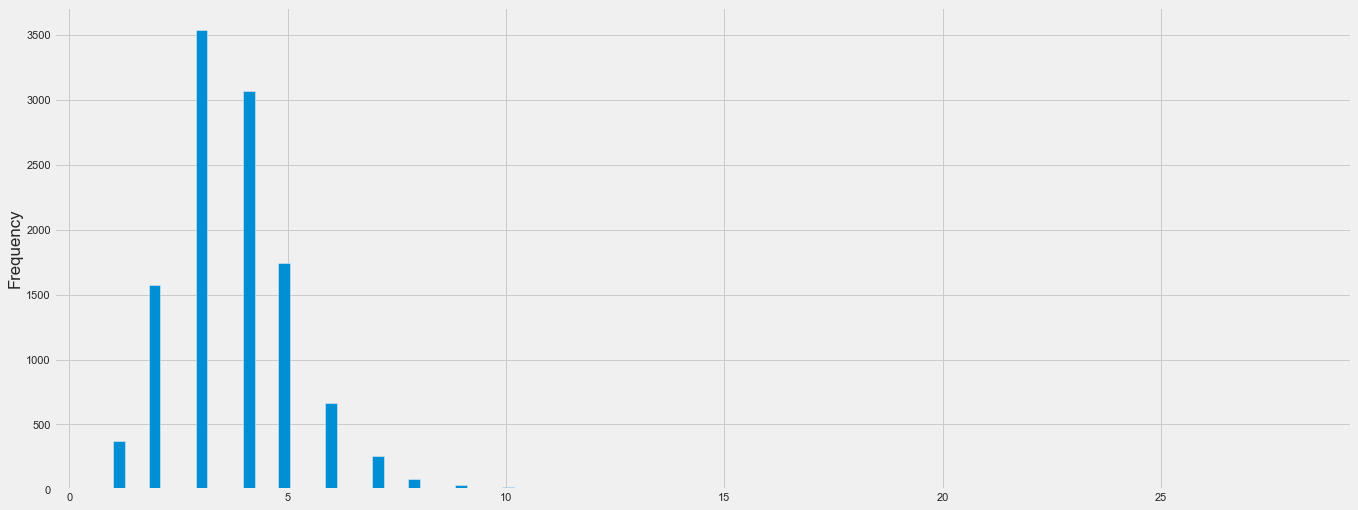

kamar_tidur


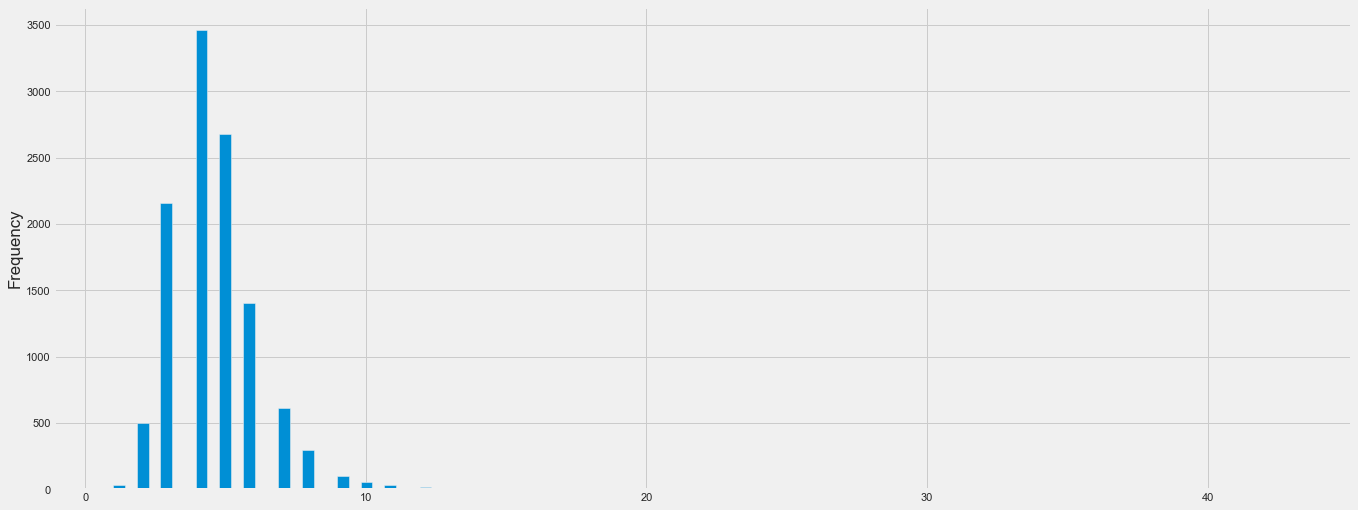

luas_bangunan


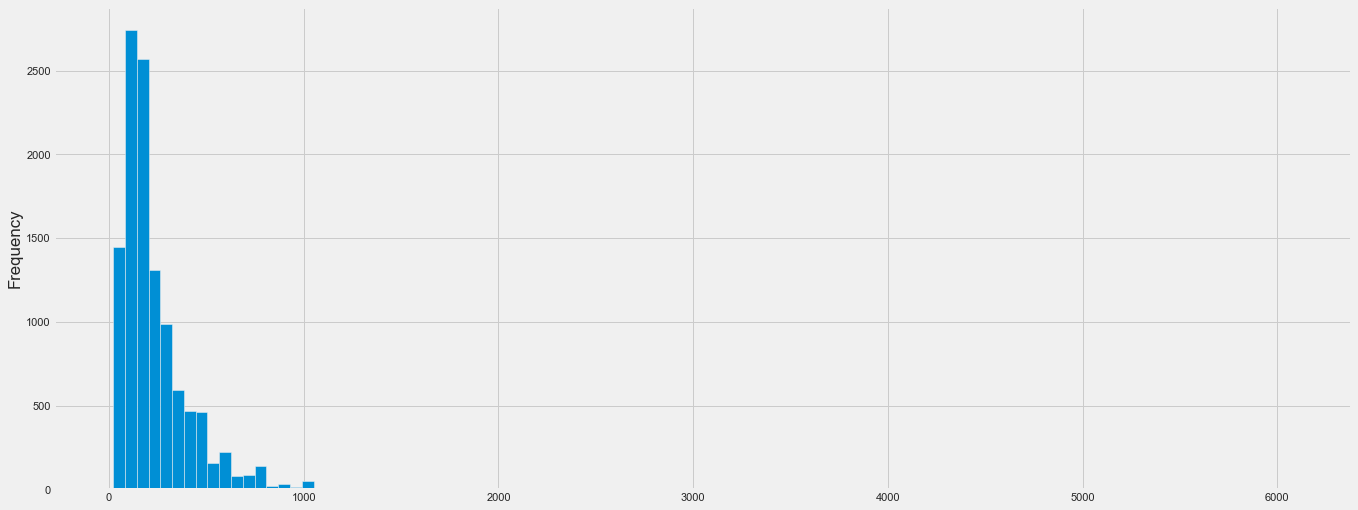

luas_tanah


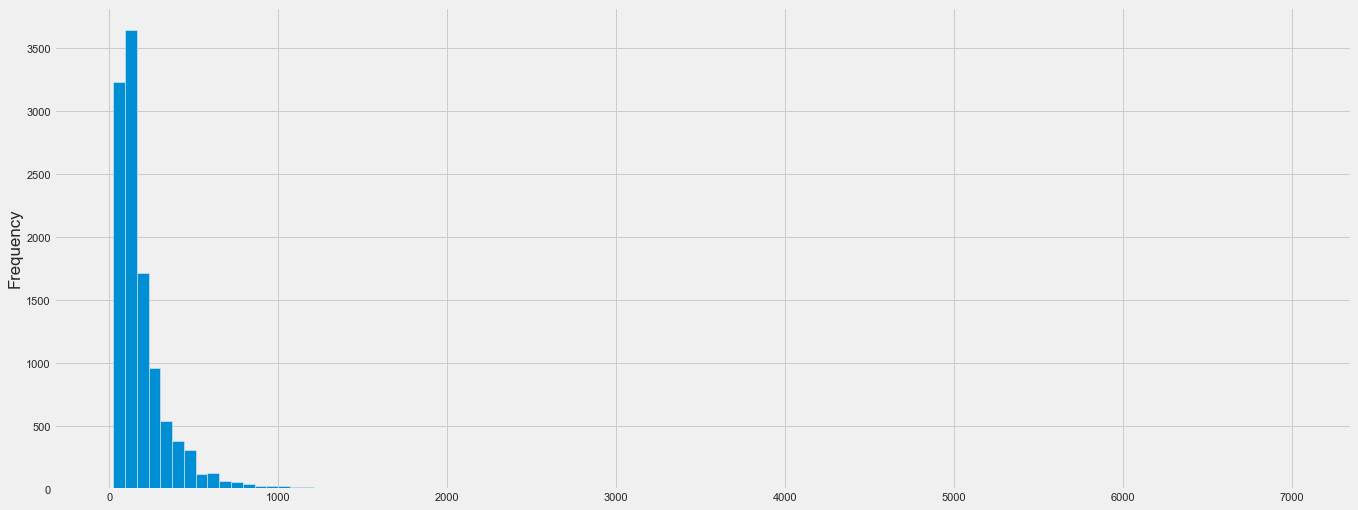

harga


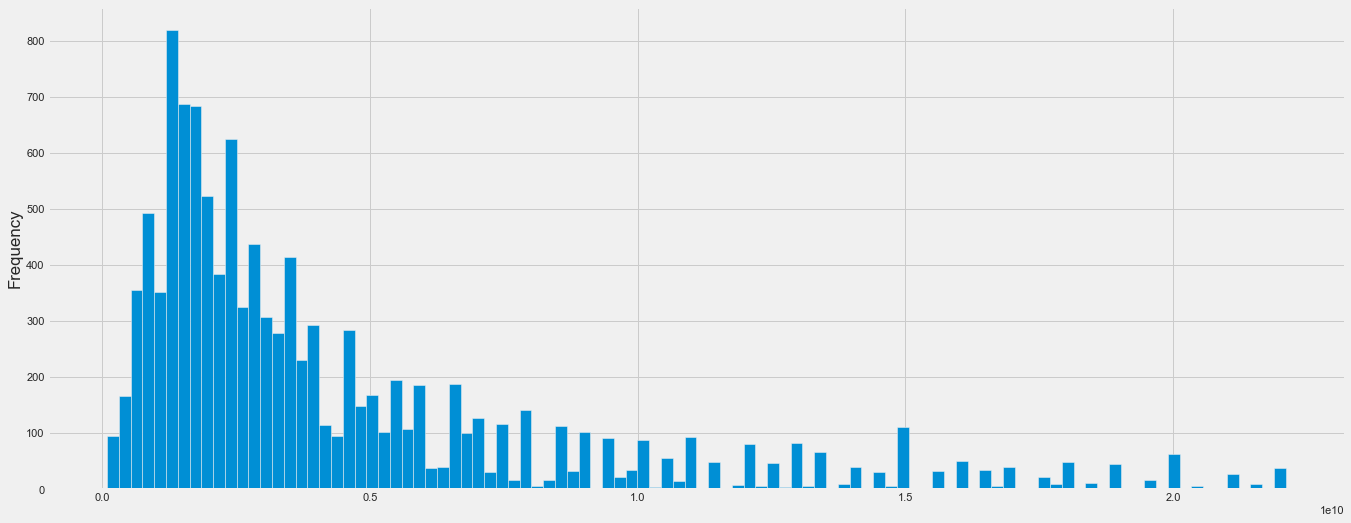

listrik


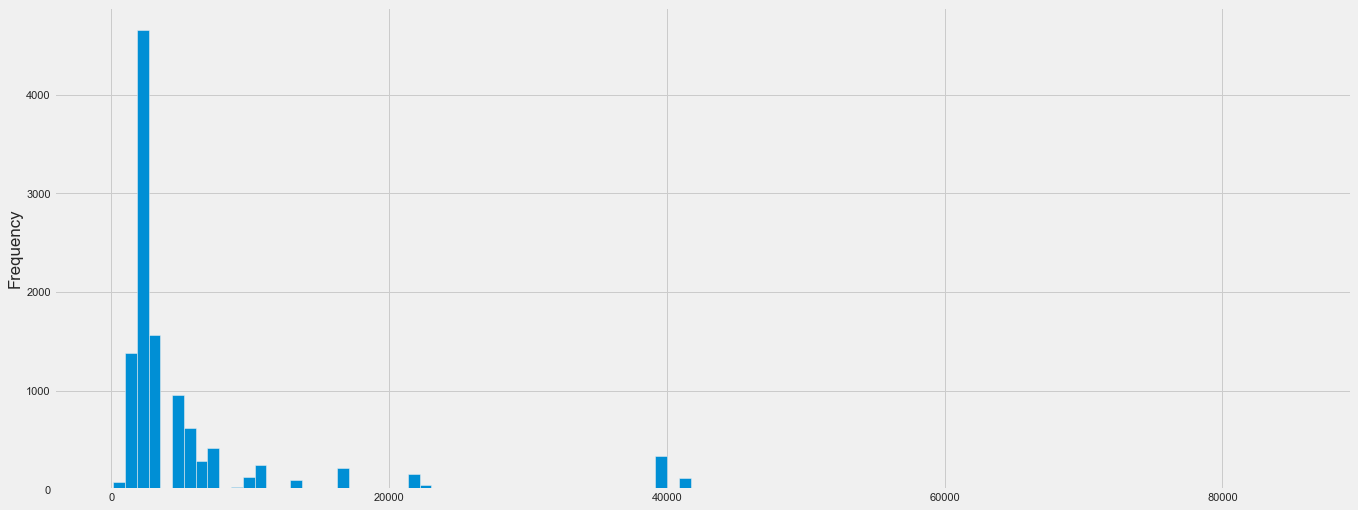

jumlah_lantai


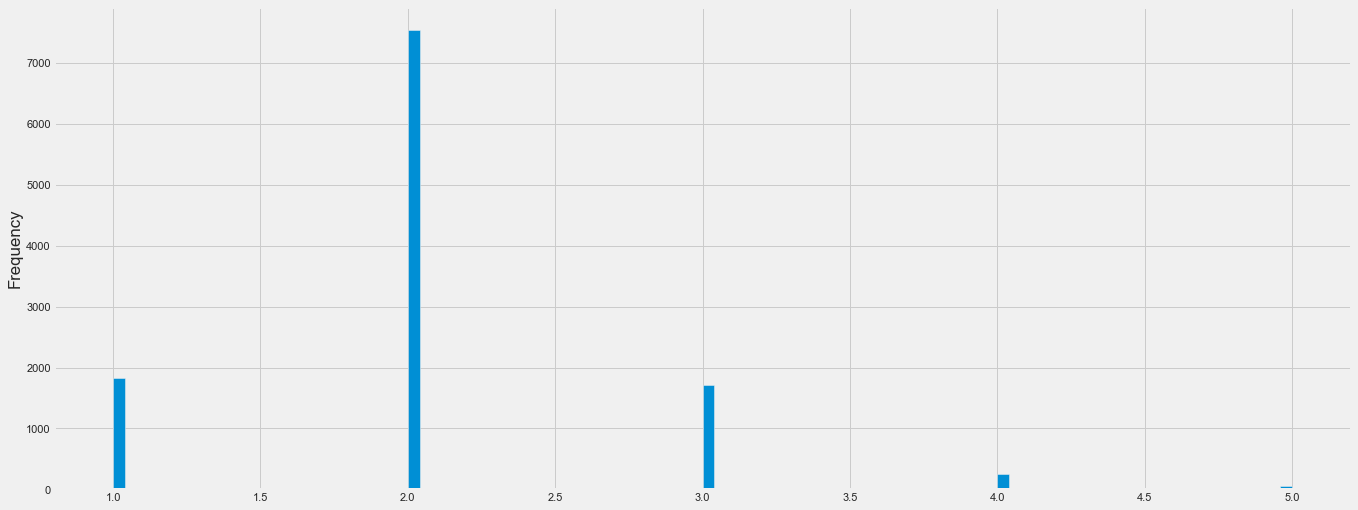

In [25]:
for i in num:
    print(i)
    df[i].plot.hist(bins = 100)
    plt.show()

kamar_mandi


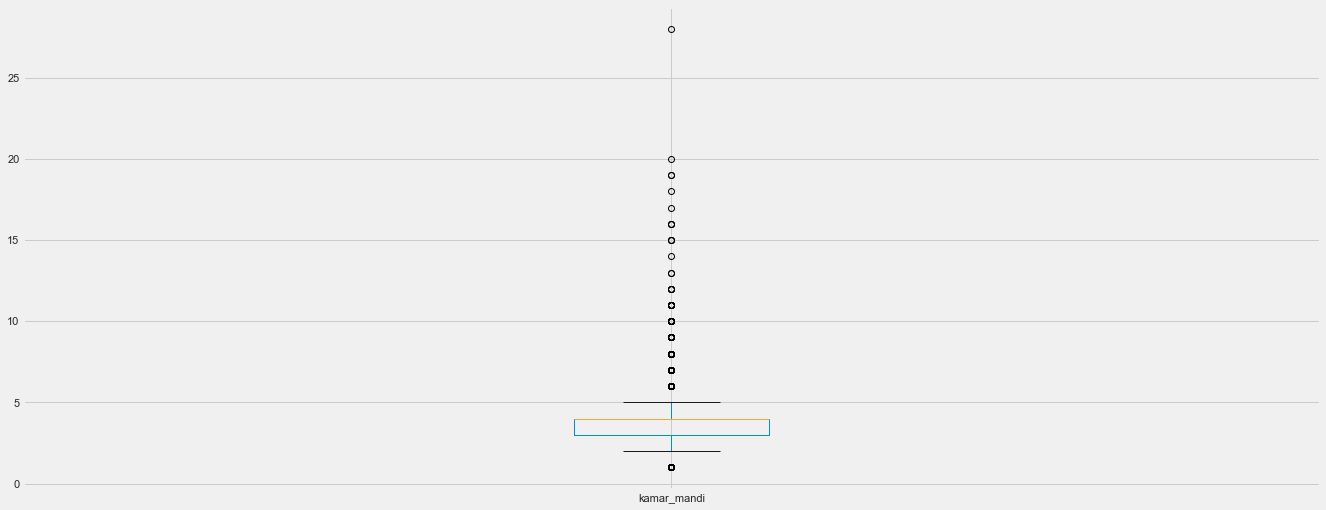

kamar_tidur


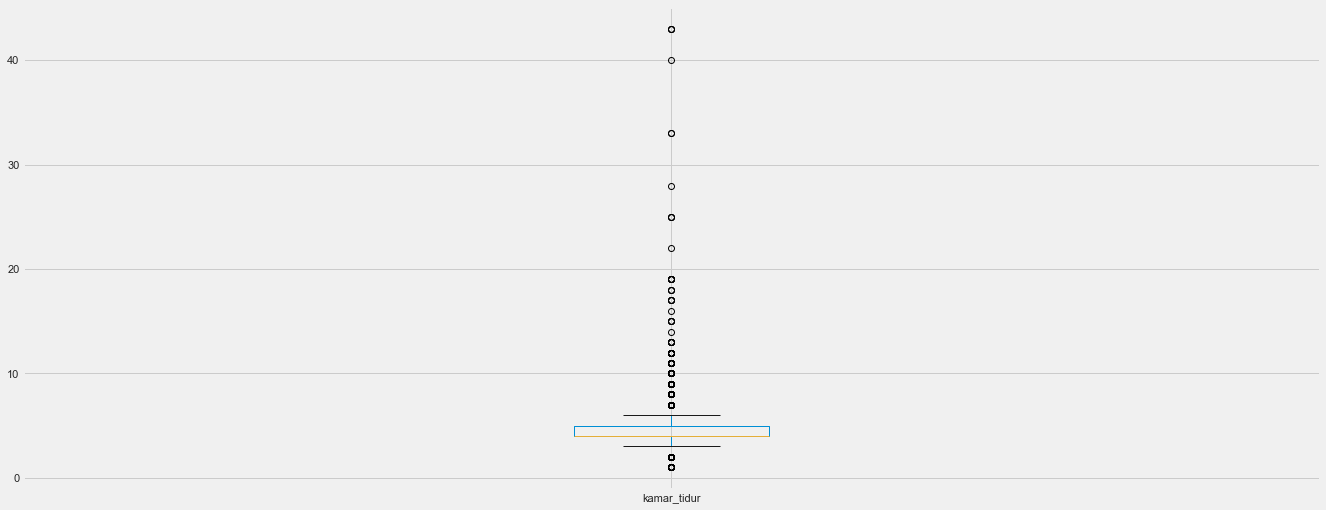

luas_bangunan


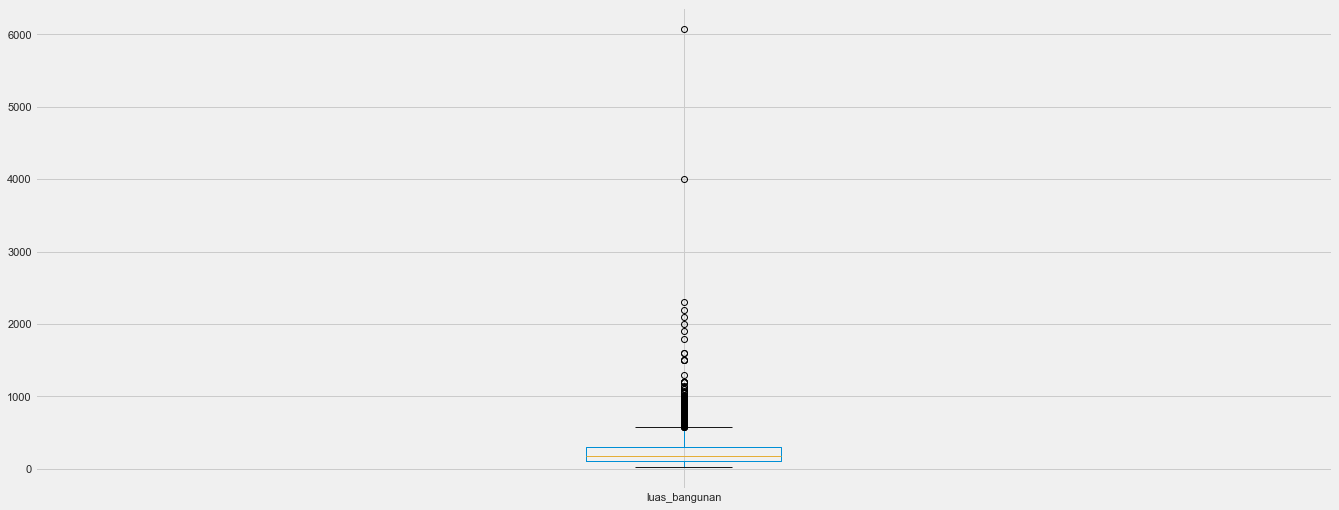

luas_tanah


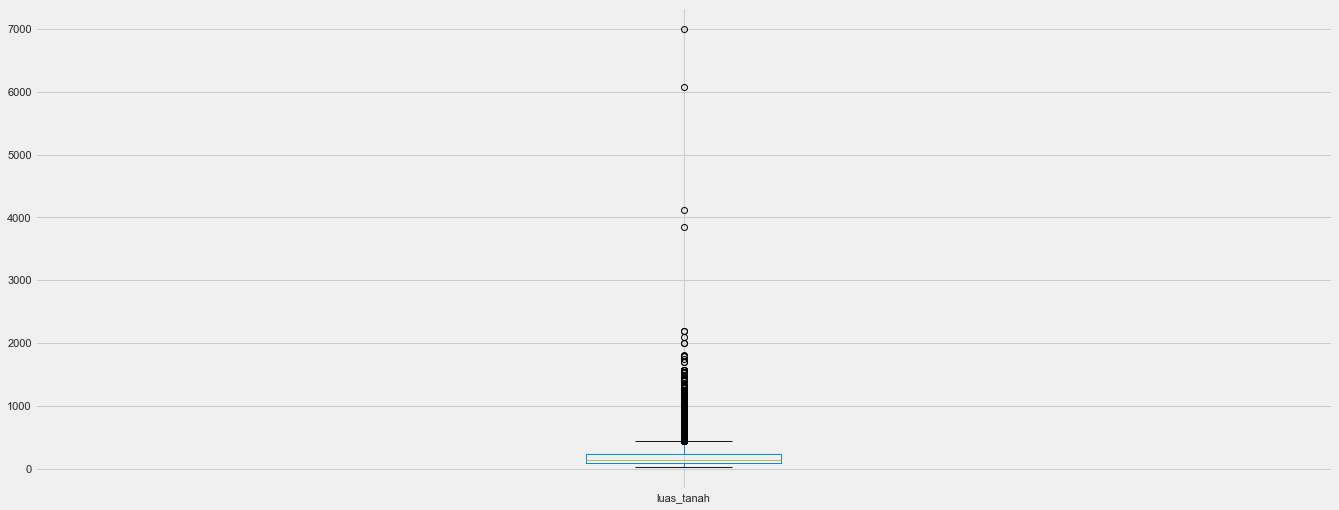

harga


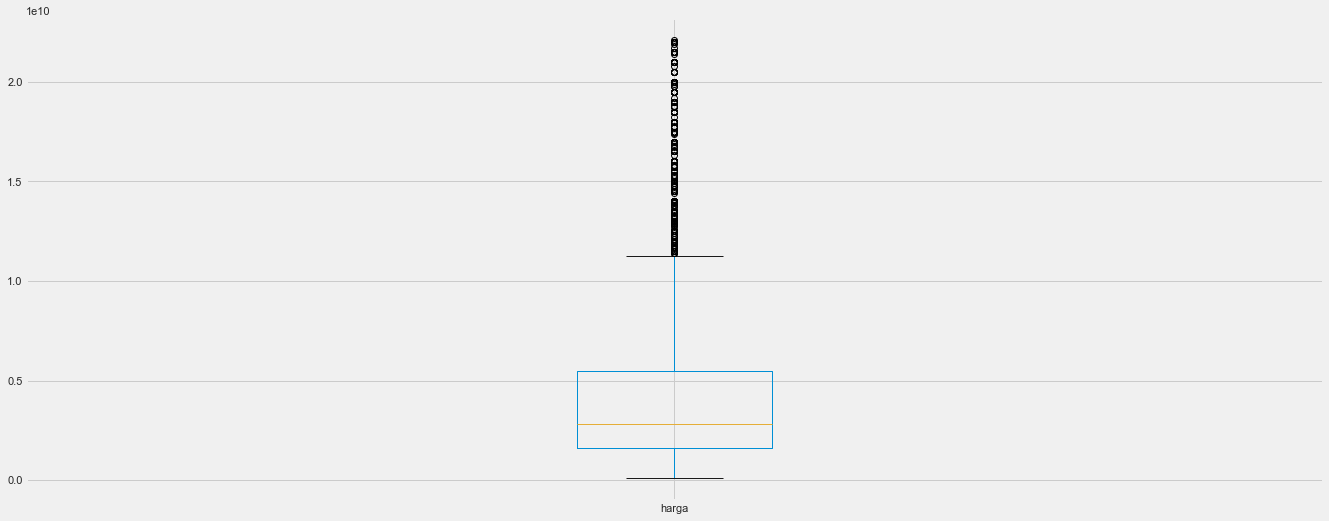

listrik


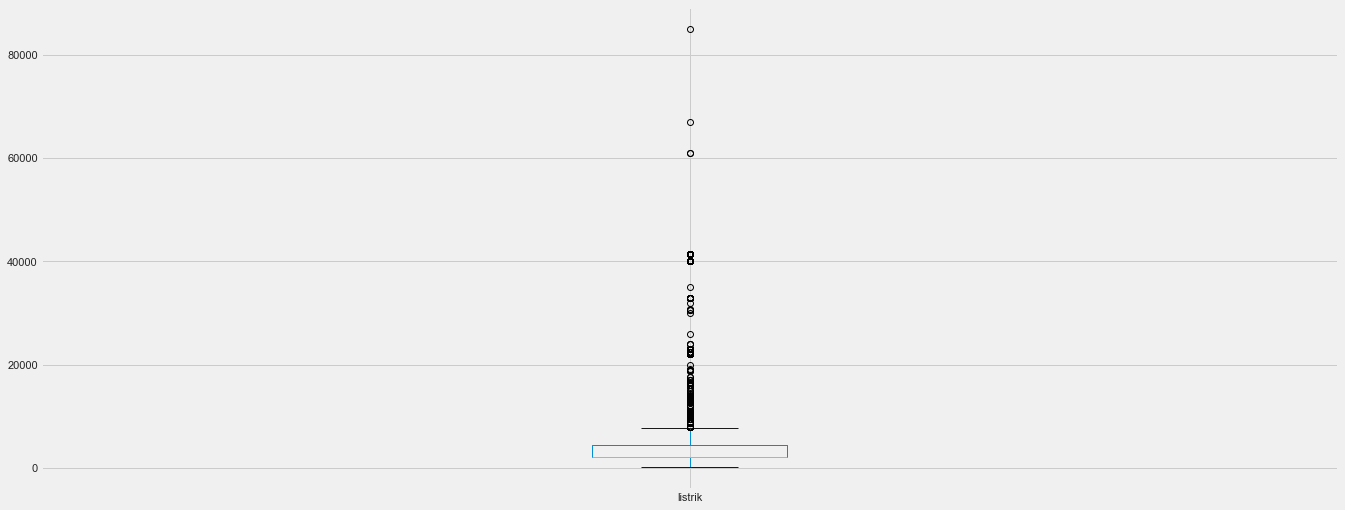

jumlah_lantai


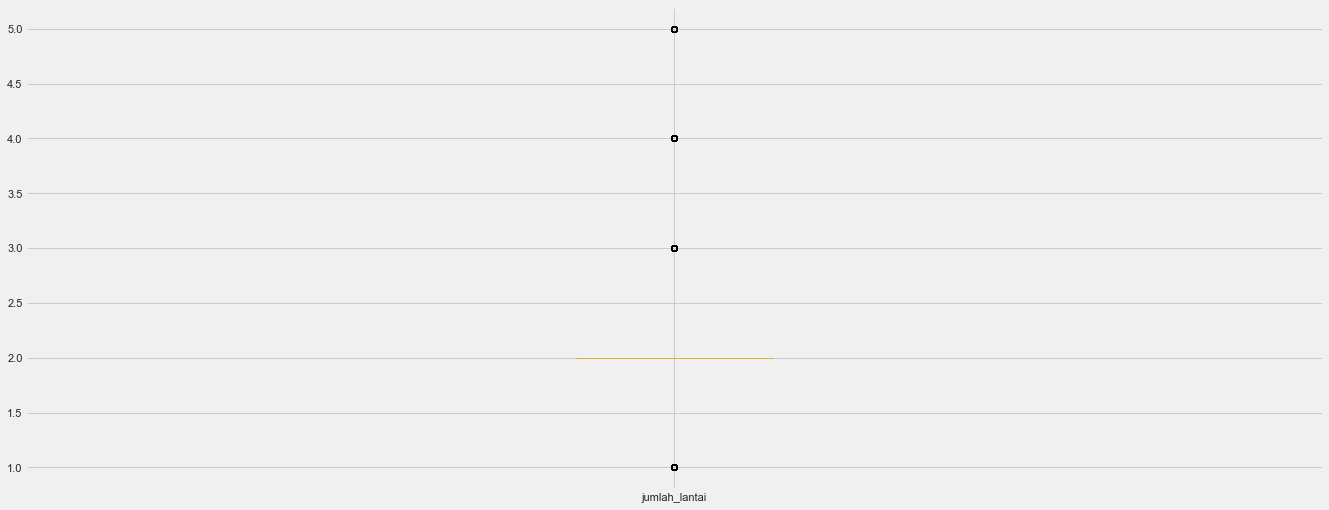

In [26]:
for i in num:
    print(i)
    df[i].plot.box()
    plt.show()

kecamatan


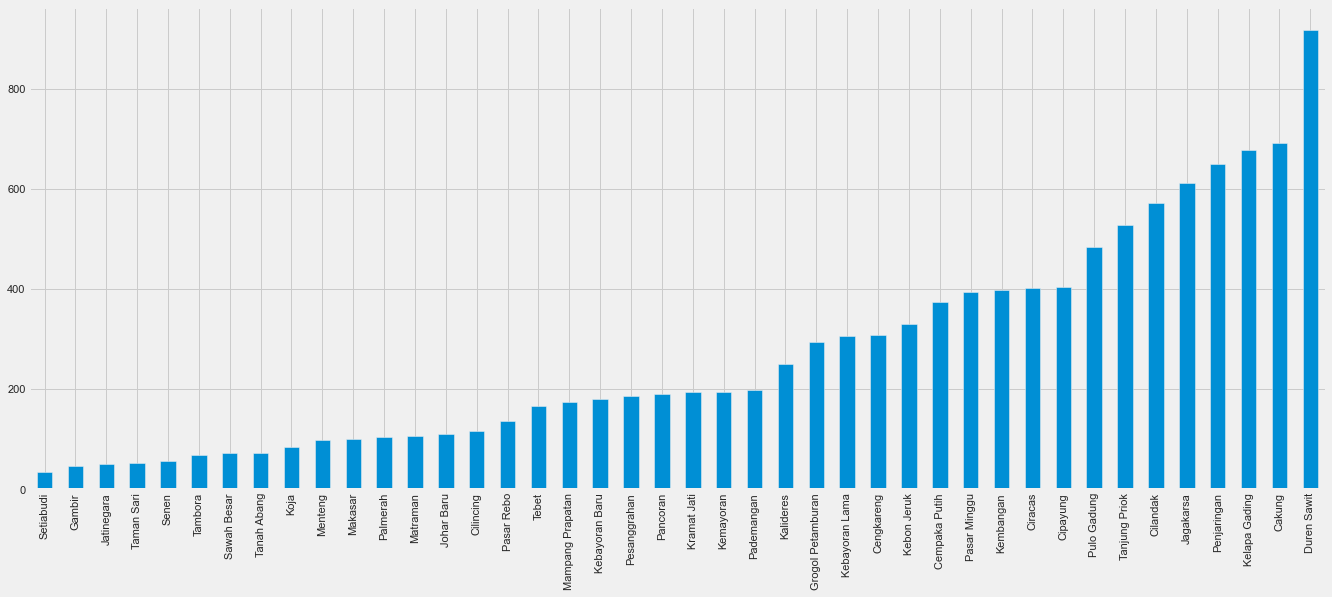

garasi


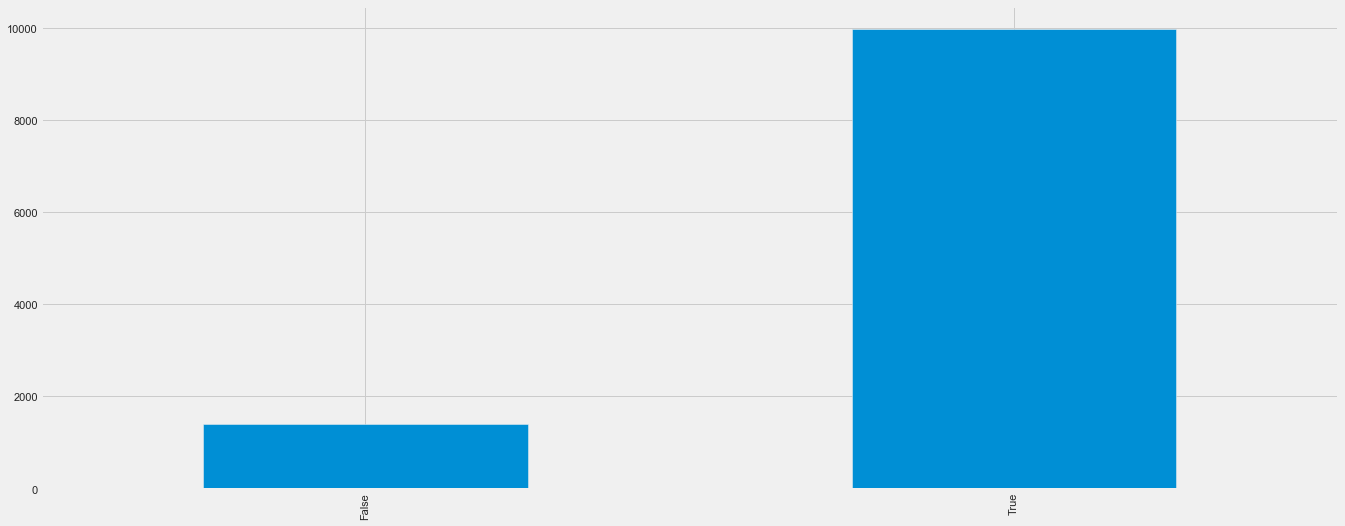

kolam_renang


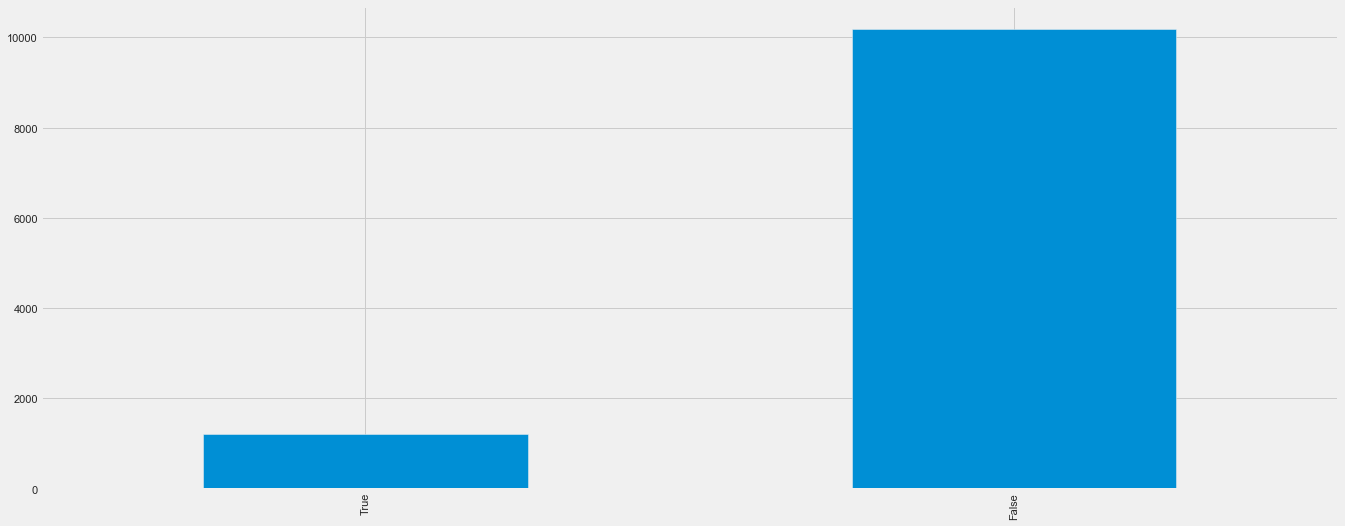

taman


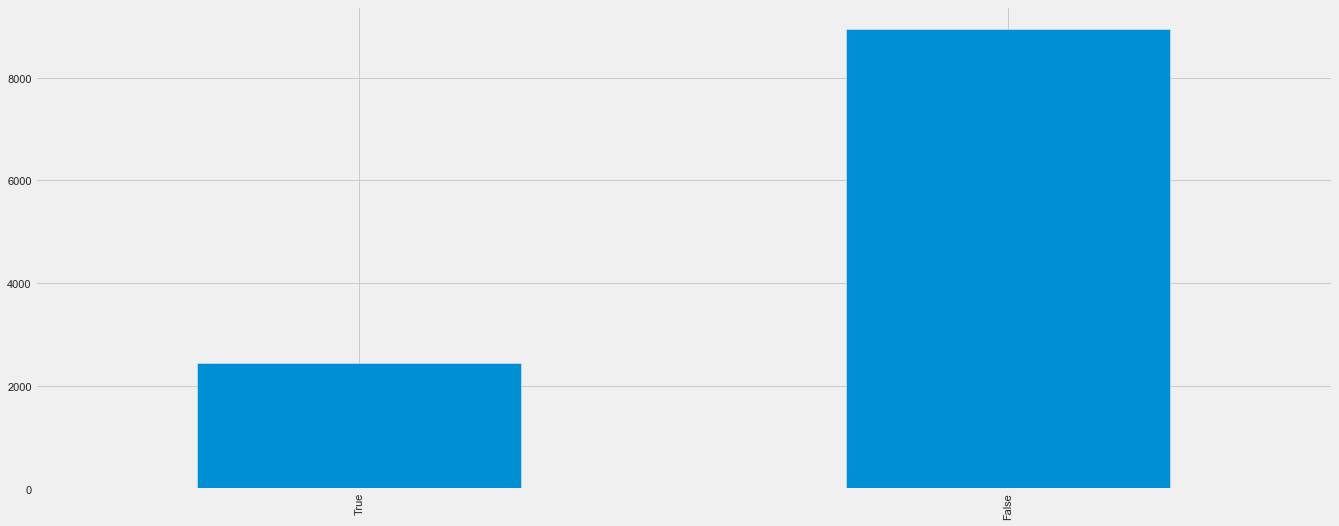

gym


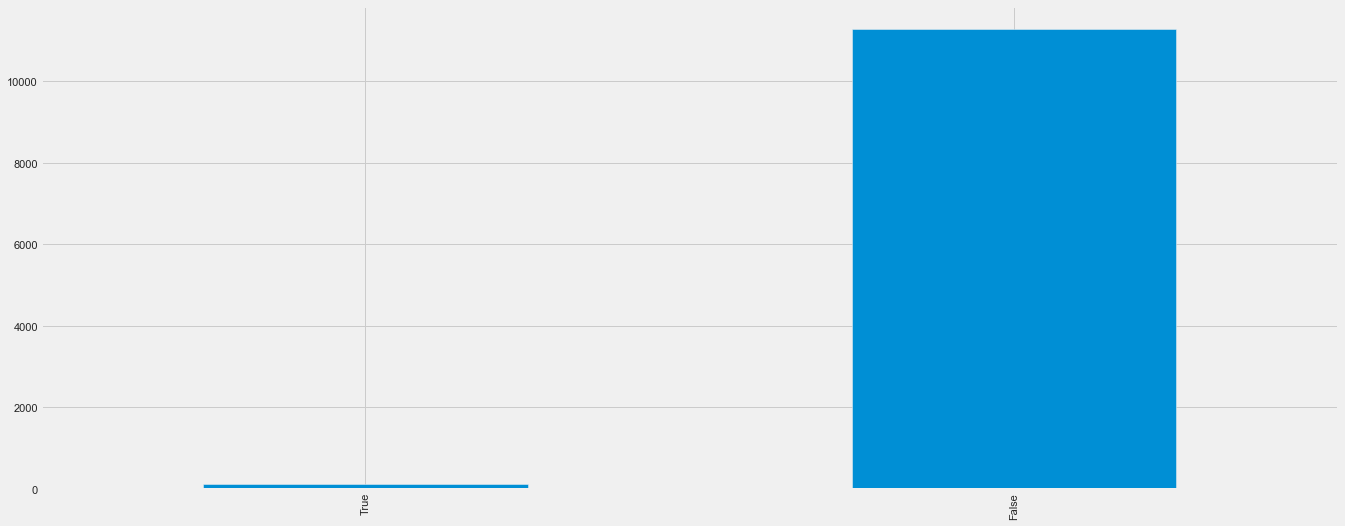

In [27]:
for i in cat:
    print(i)
    df[i].value_counts().sort_values().plot.bar()
    plt.show()

Masukin target (harga)

kamar_mandi


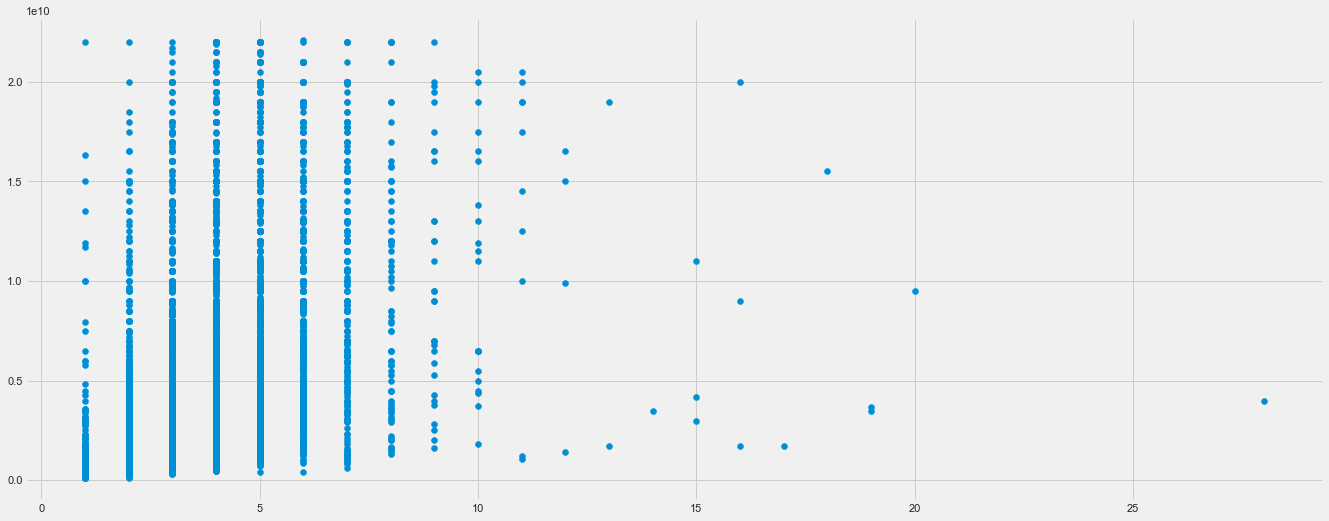

kamar_tidur


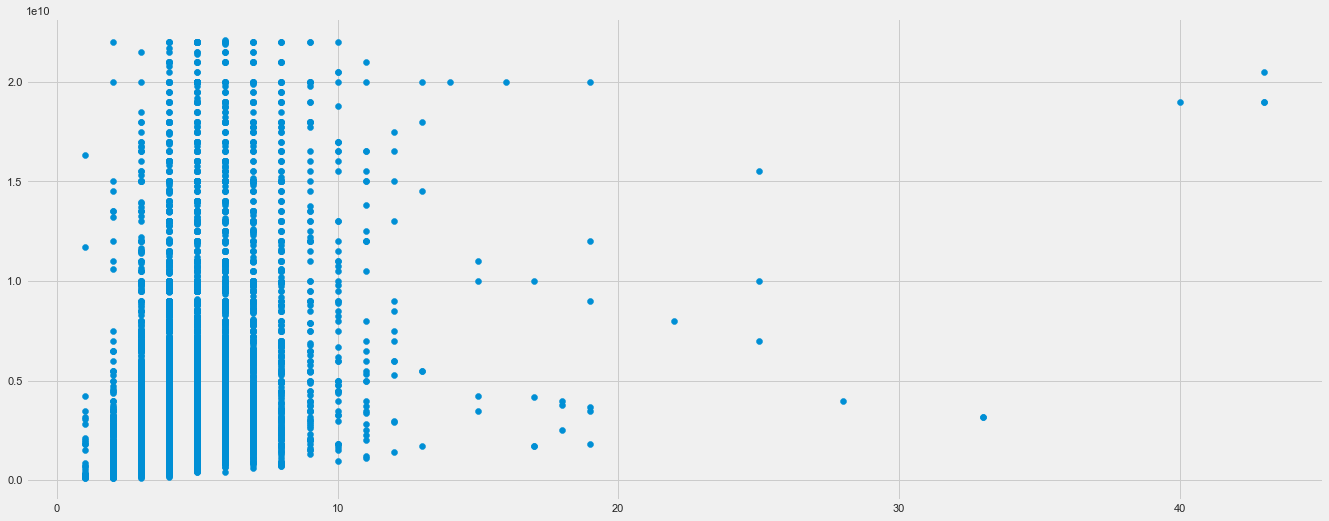

luas_bangunan


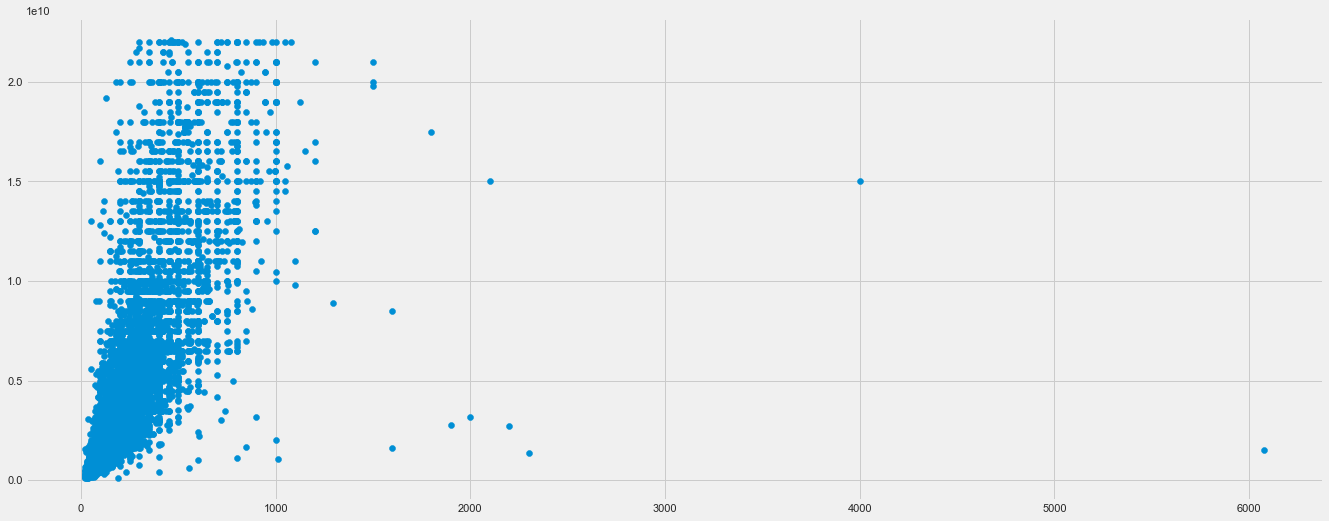

luas_tanah


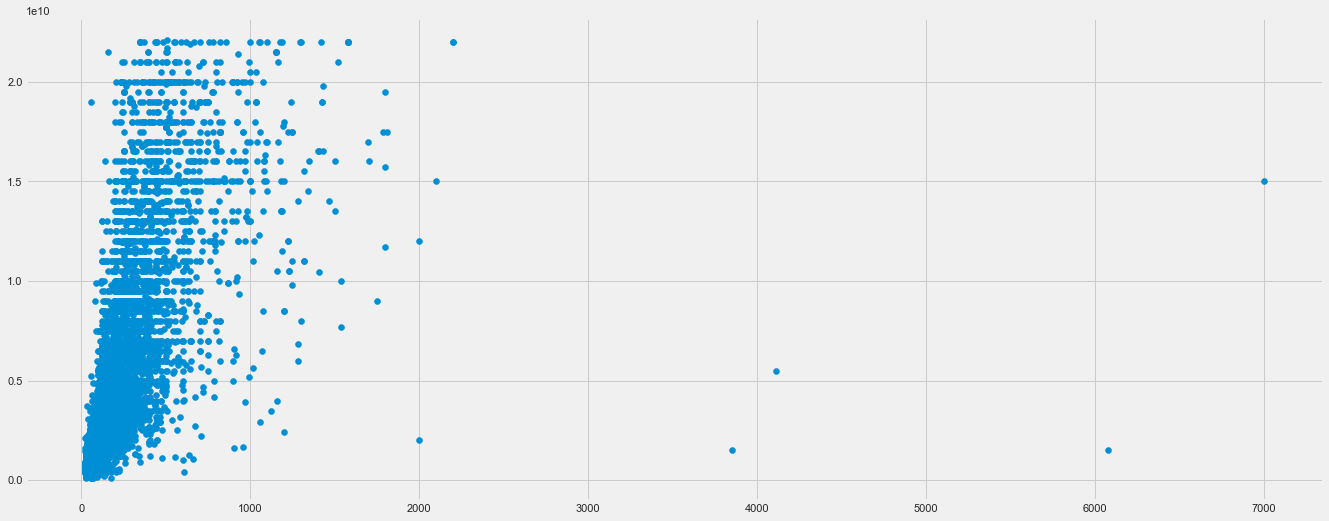

listrik


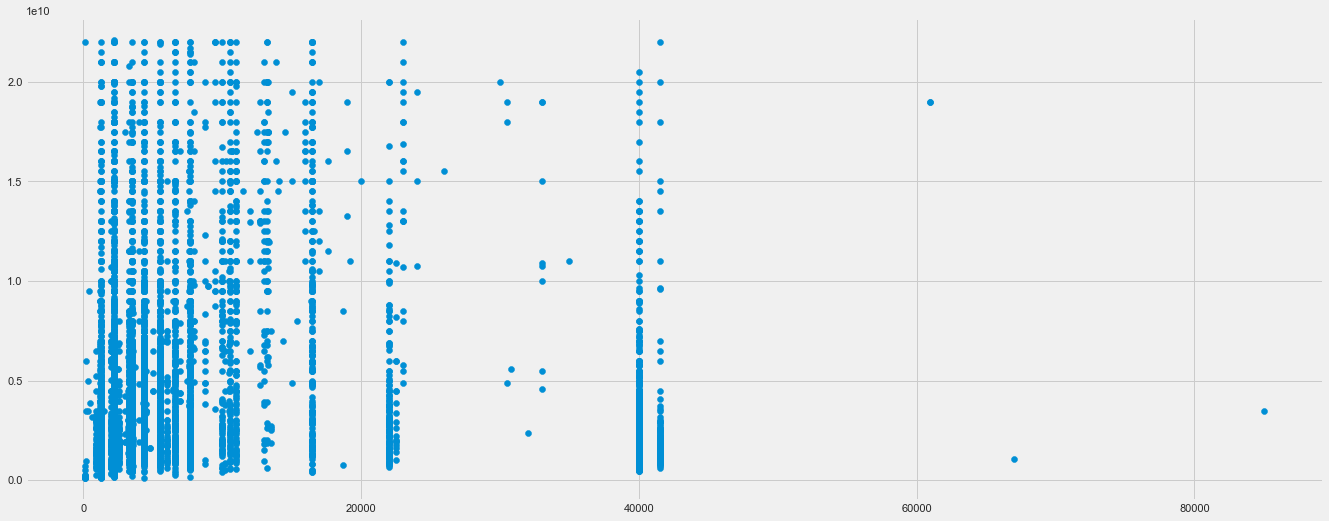

jumlah_lantai


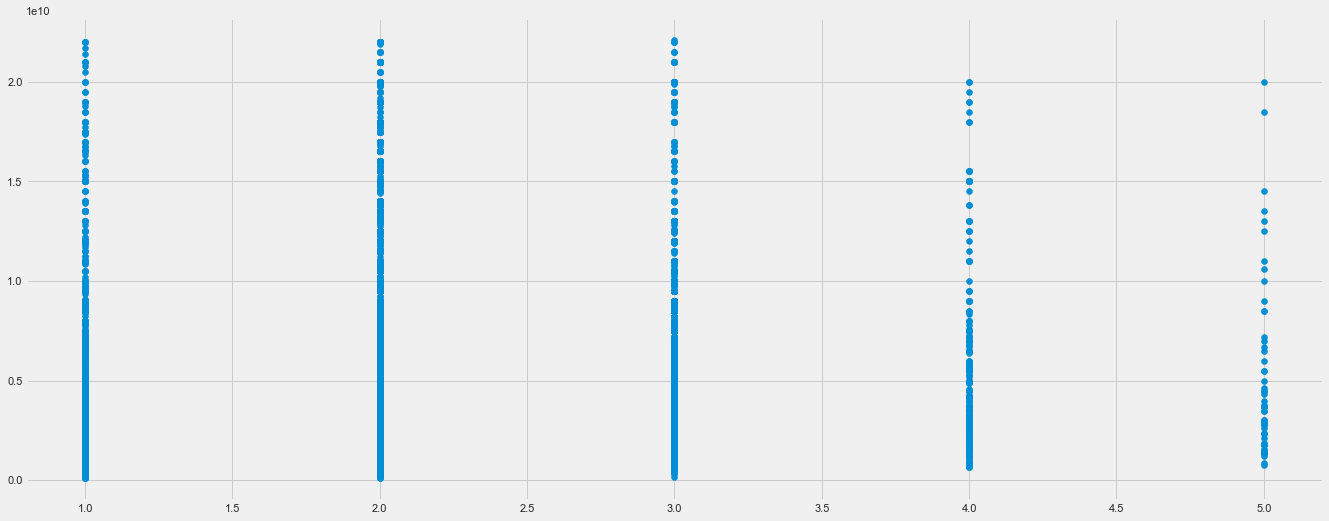

kecamatan


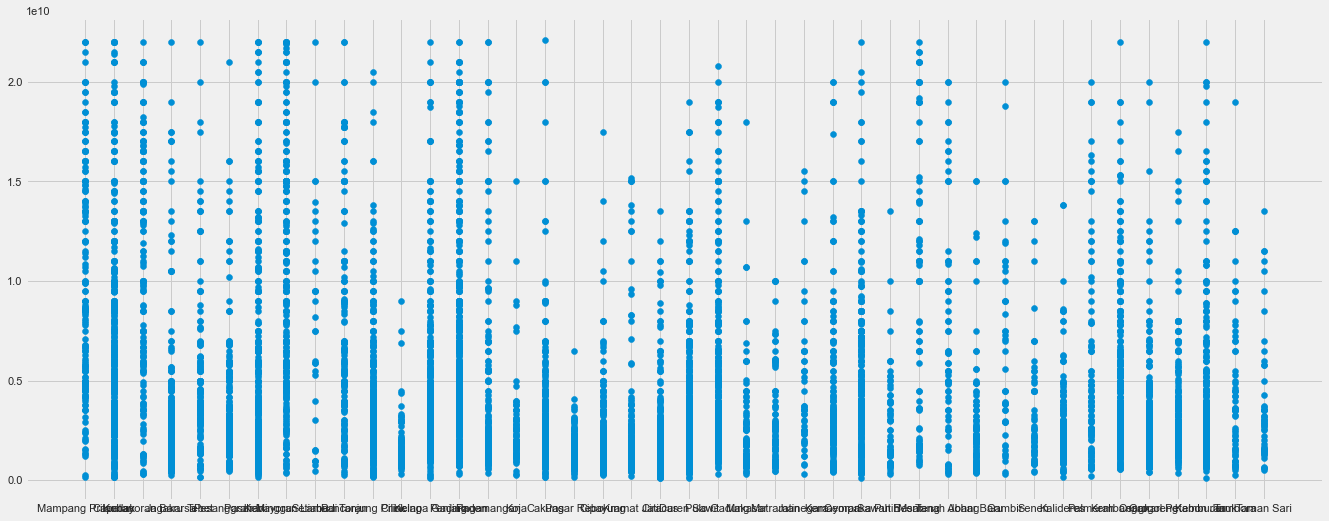

garasi


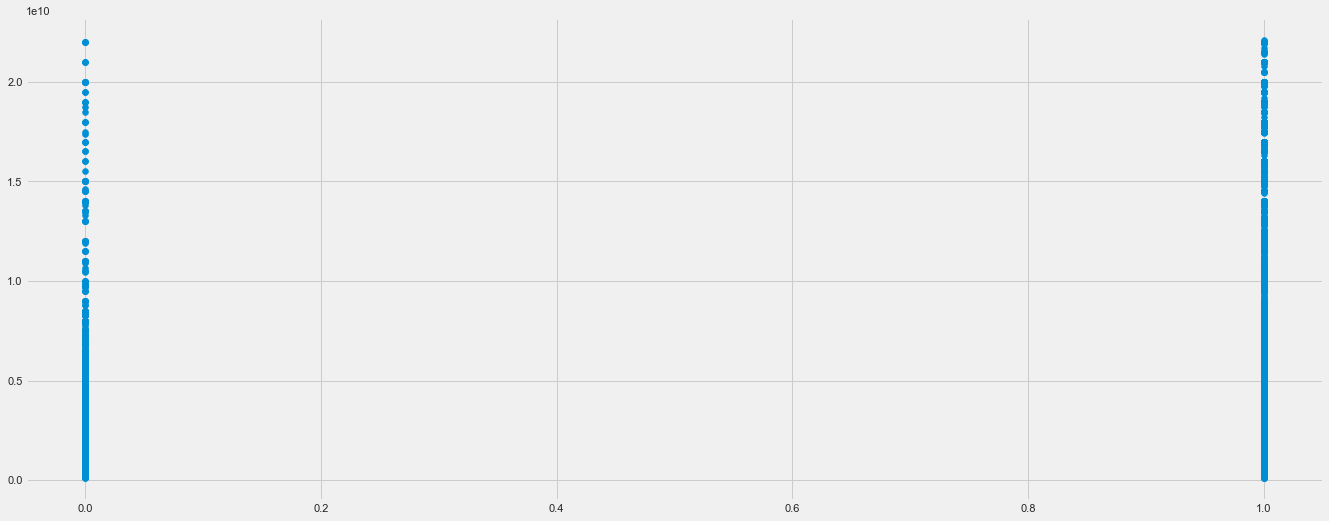

kolam_renang


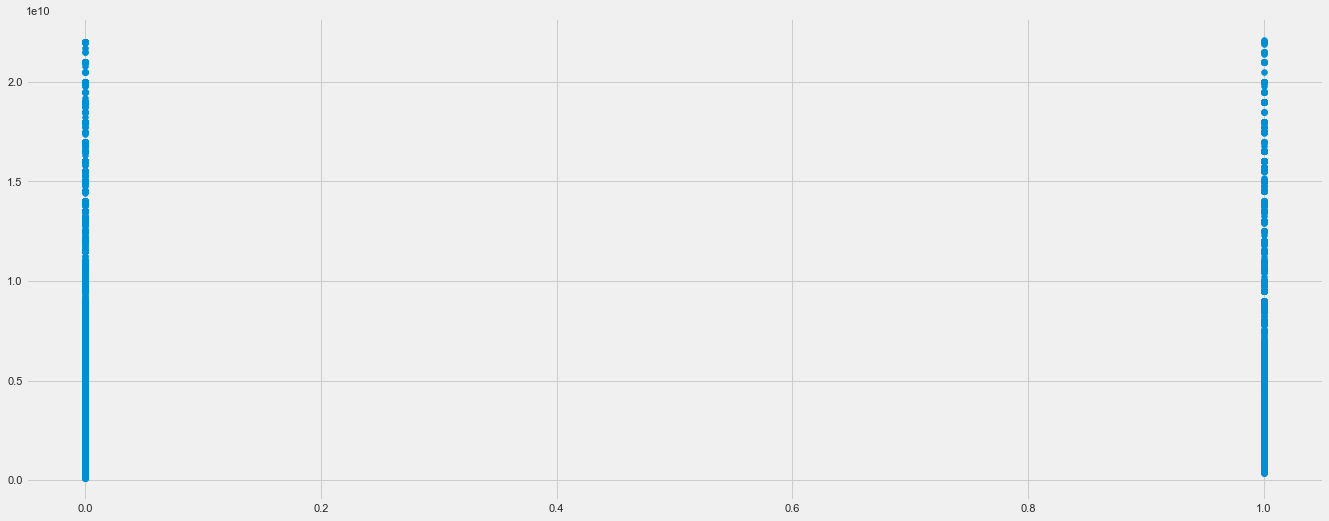

taman


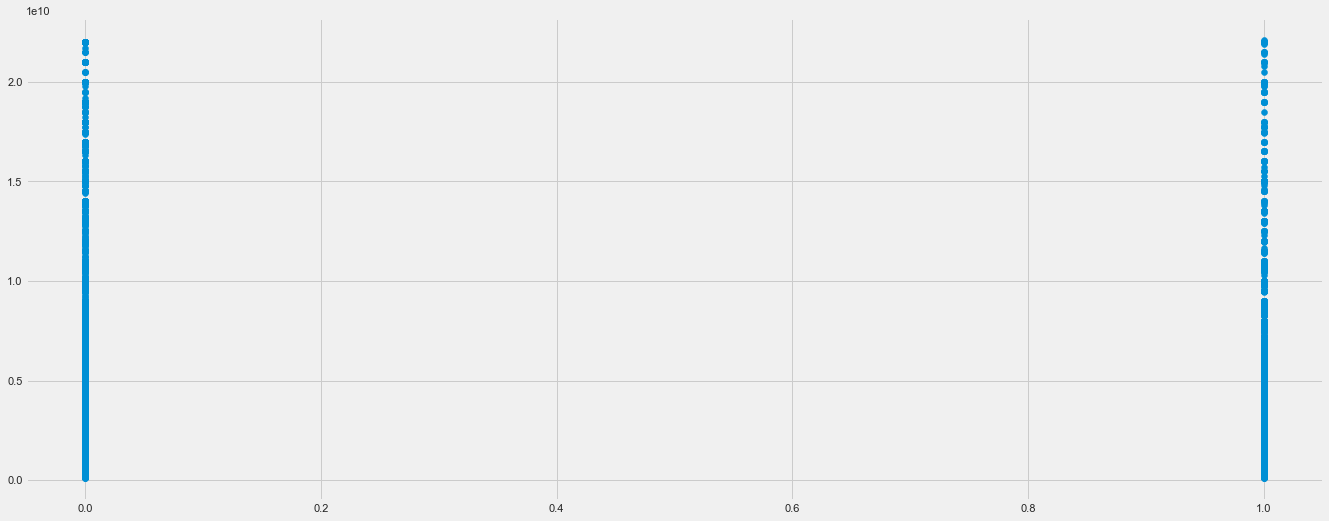

gym


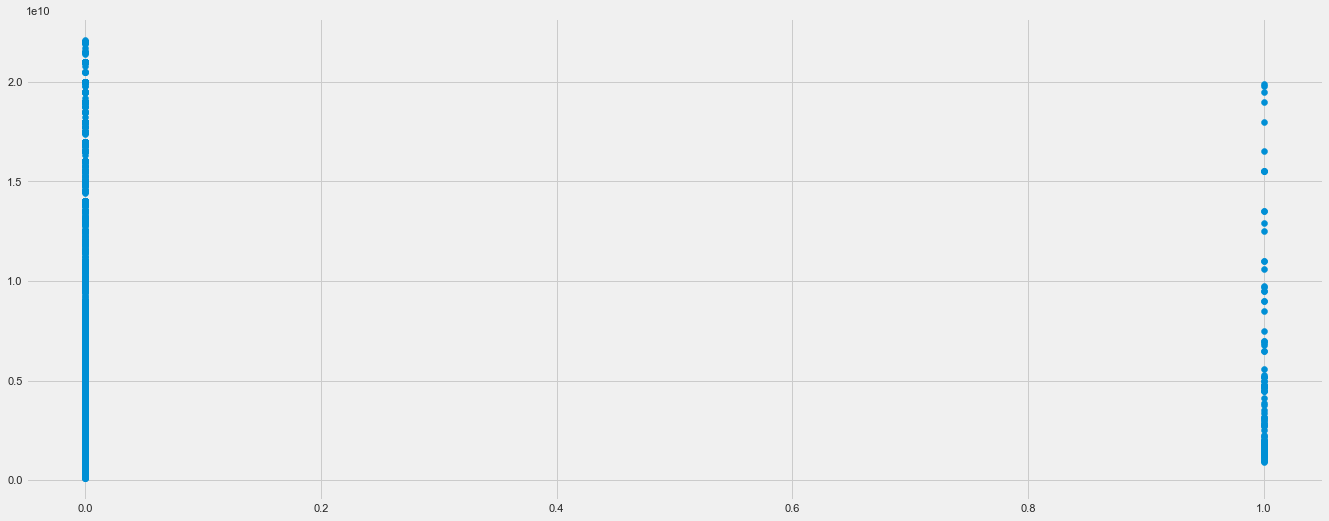

In [28]:
for i in num+cat:
    if i != 'harga':
        print(i)
        plt.scatter(df[i],df['harga'])
        plt.show()

kecamatan


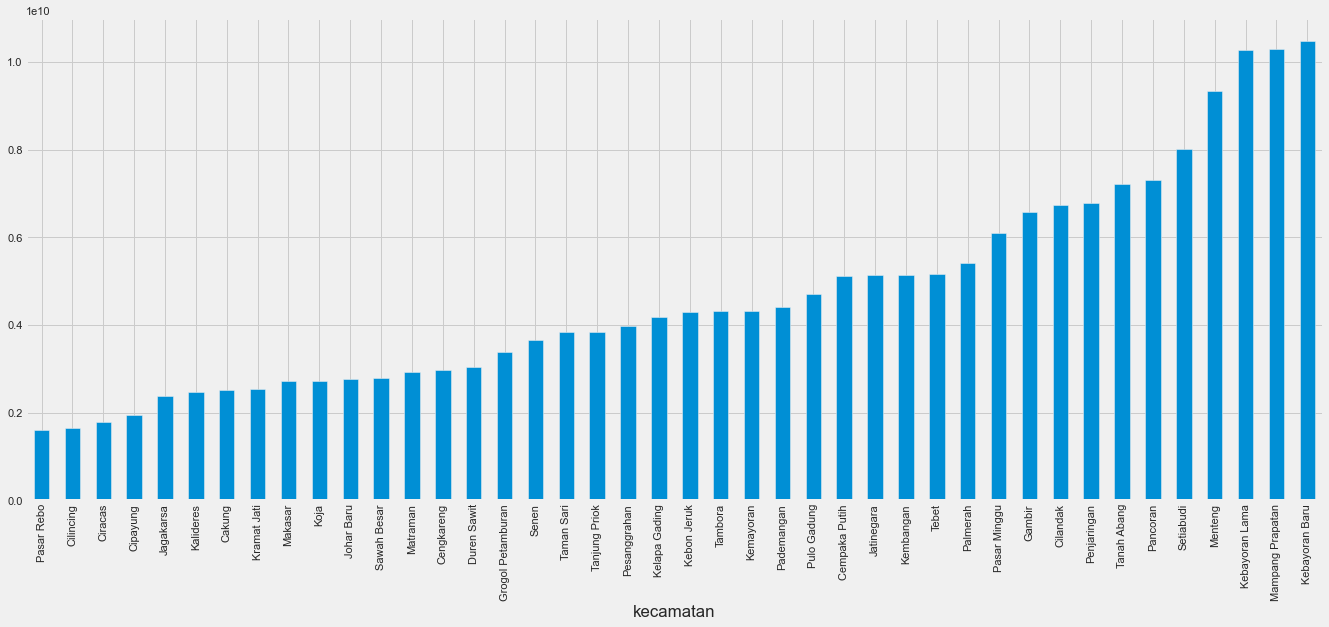

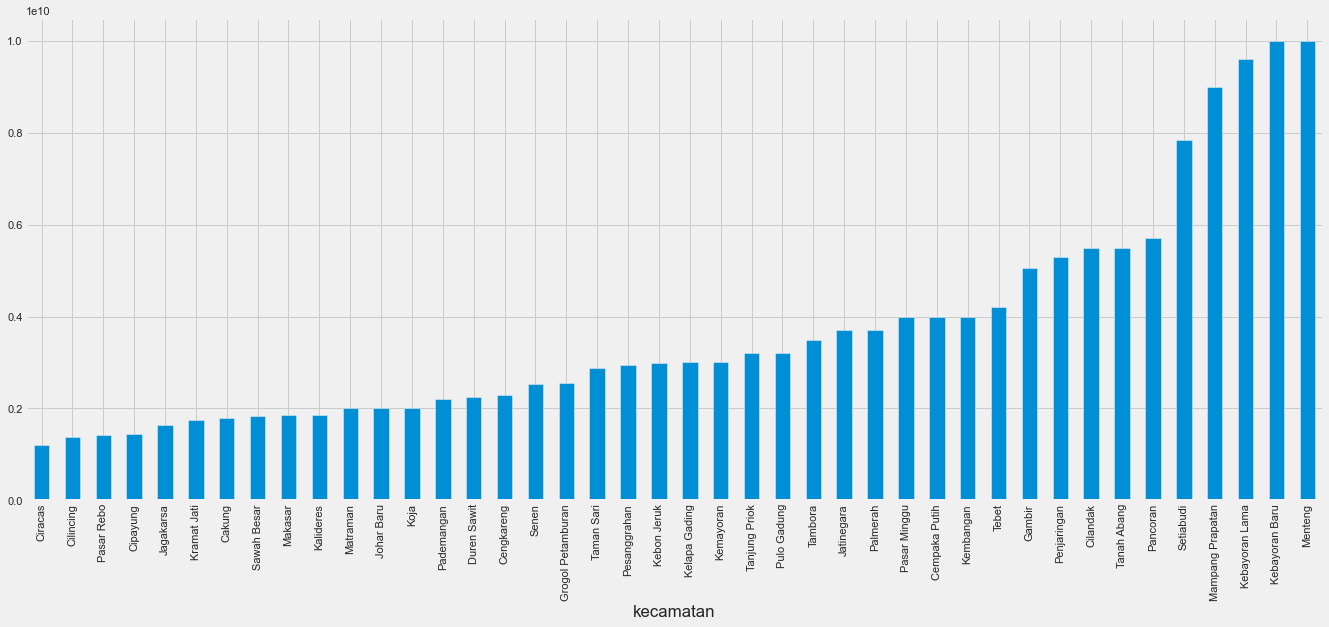

garasi


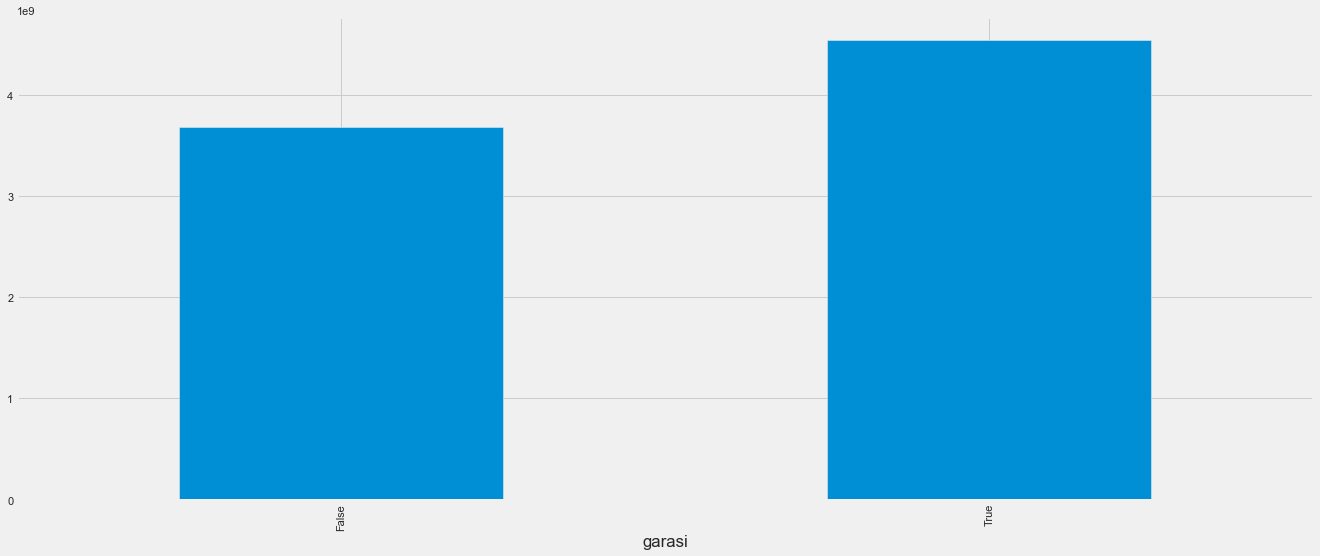

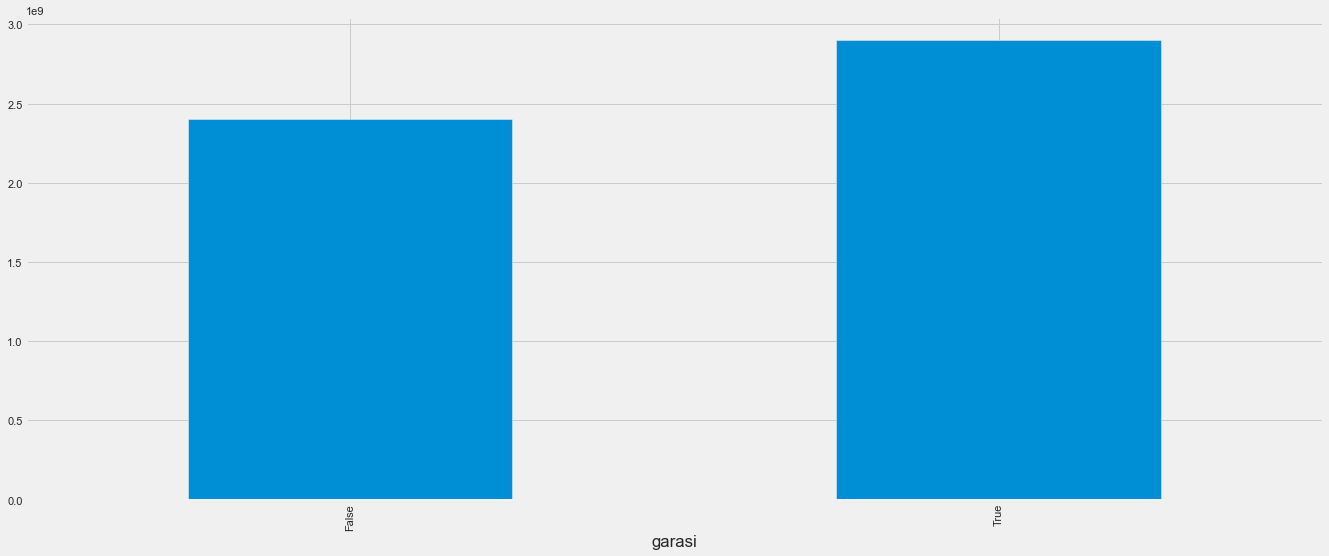

kolam_renang


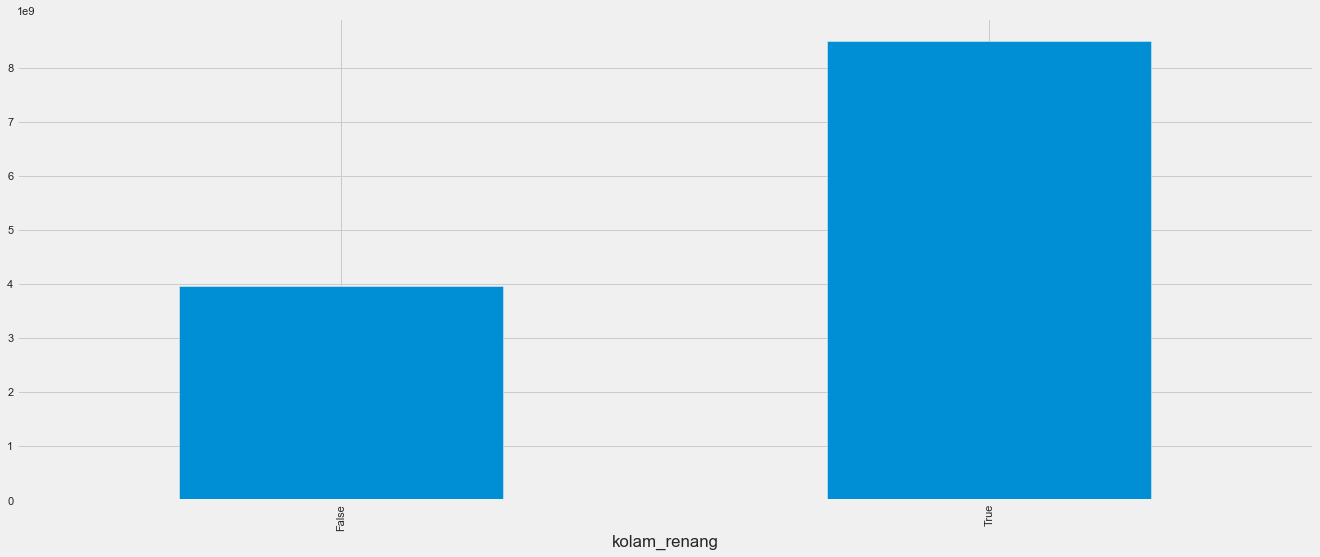

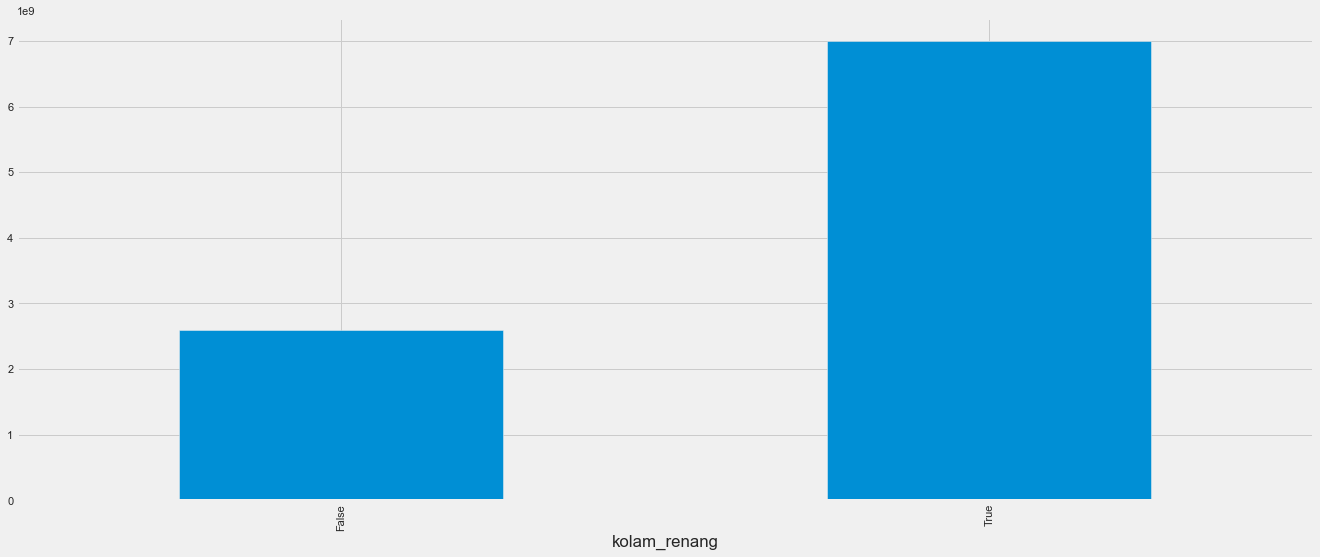

taman


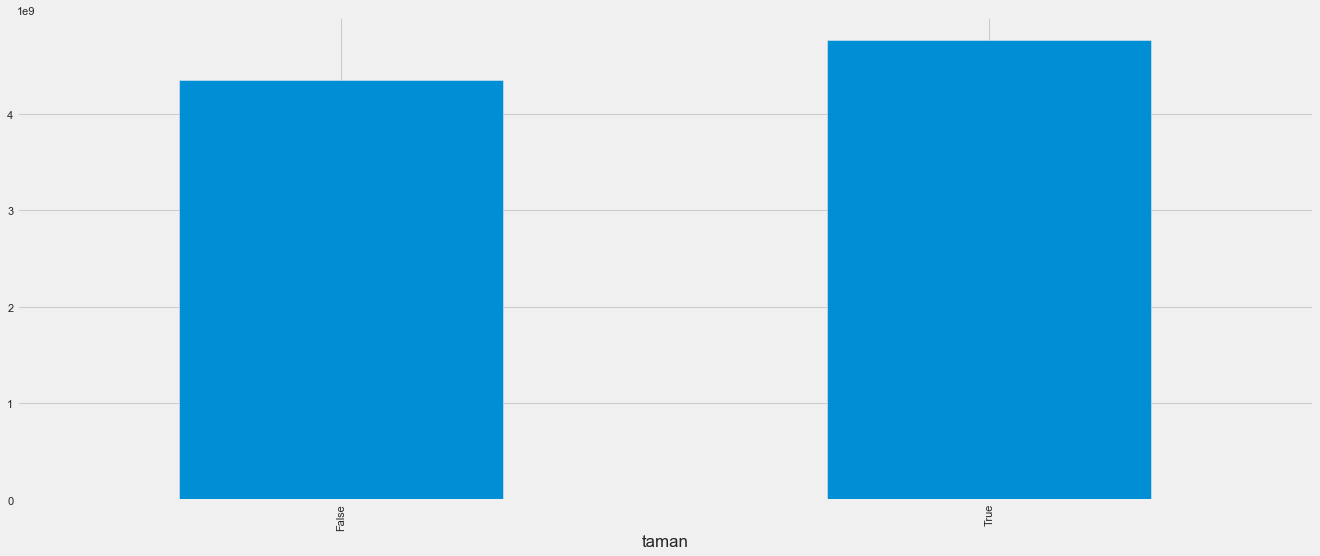

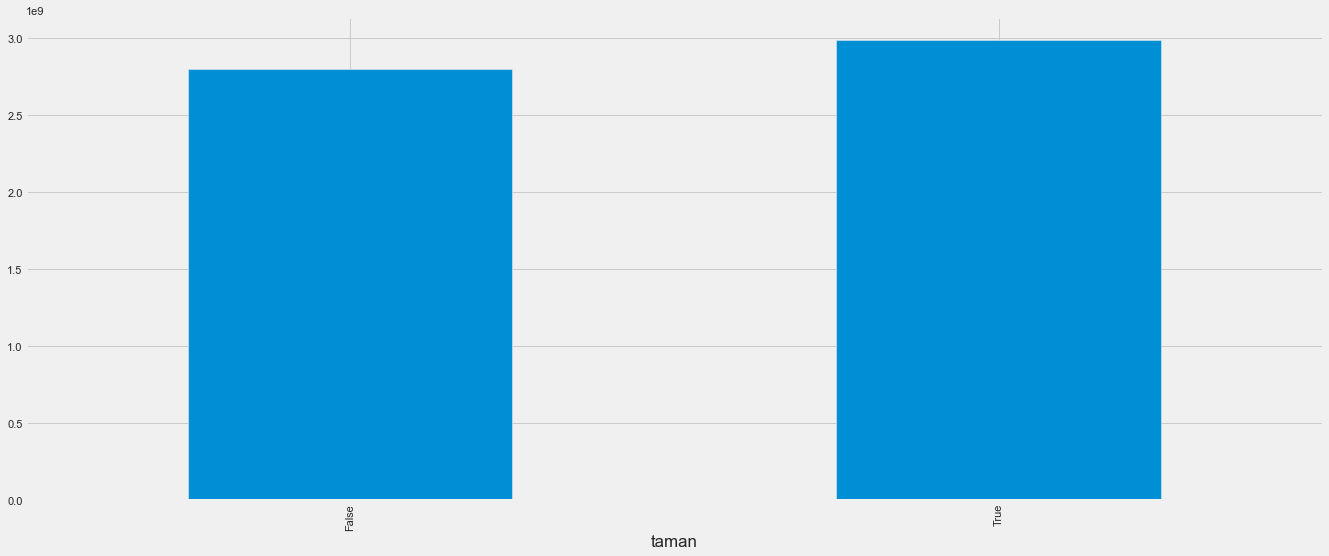

gym


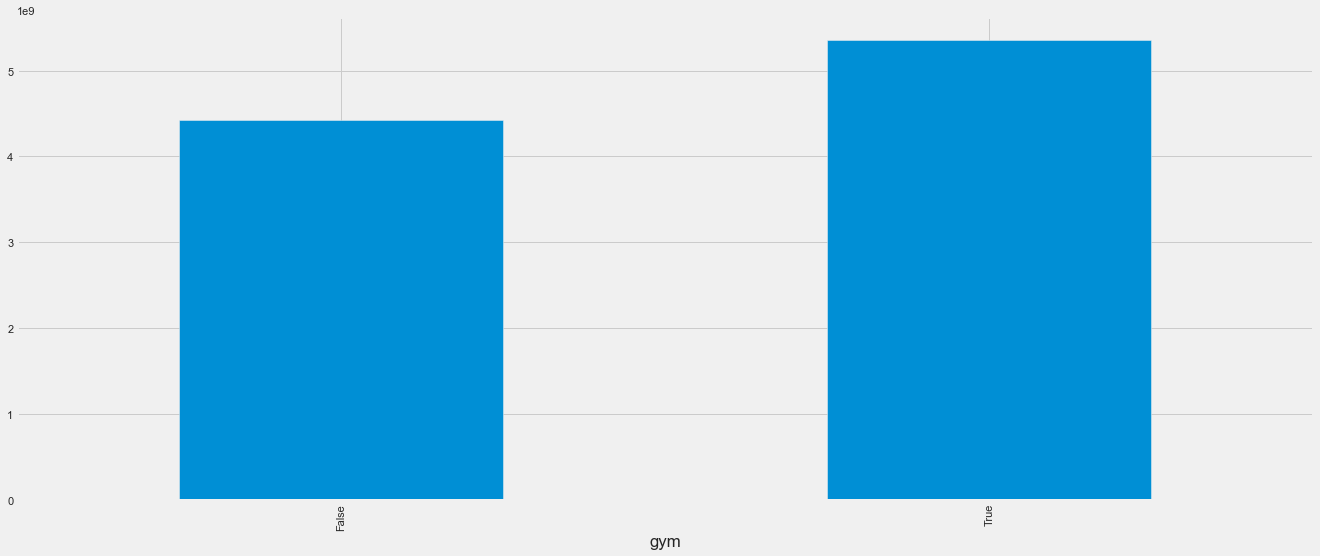

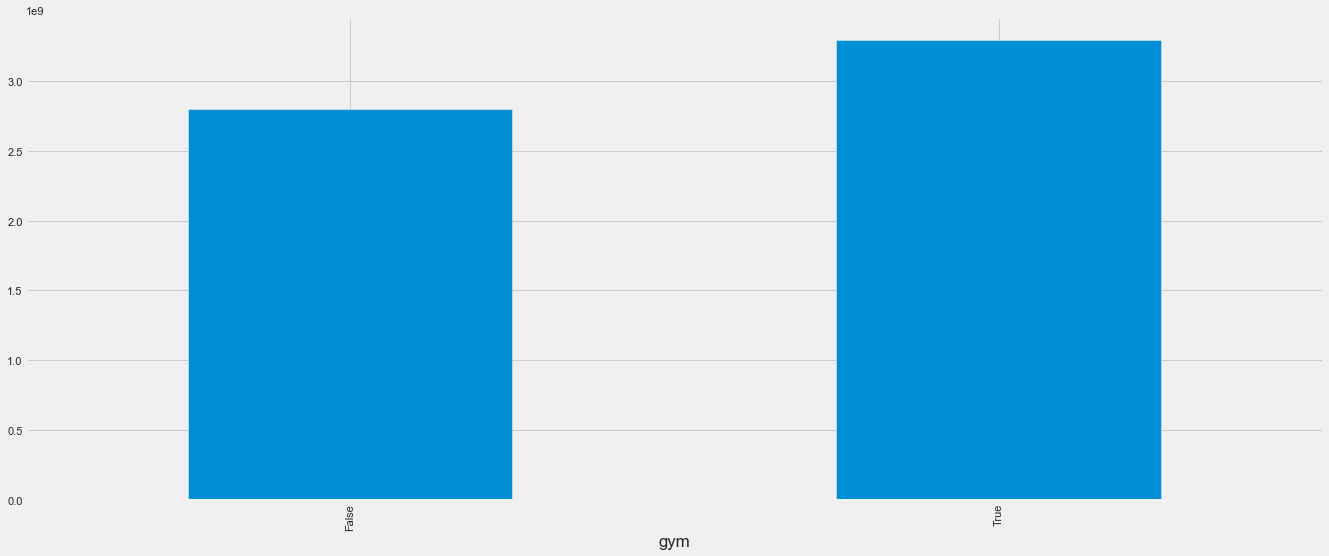

In [29]:
for i in cat:
    print(i)
    df.groupby(i)['harga'].mean().sort_values().plot.bar()
    plt.show()
    df.groupby(i)['harga'].median().sort_values().plot.bar()
    plt.show()

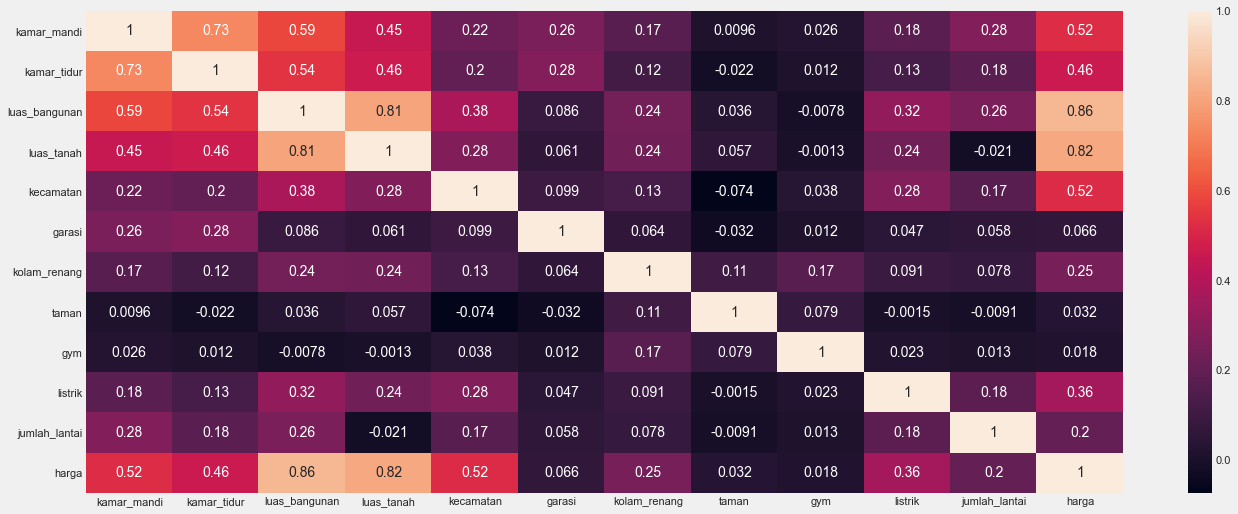

In [30]:
sns.heatmap(initial_data.corr(method = 'spearman'),annot=True)
plt.show()

In [31]:
df_experiment = df.copy()
df_experiment = df_experiment.drop(
    ['garasi','jumlah_lantai','gym'],  axis = 1
)

In [32]:
df_experiment.describe()

,kamar_mandi,kamar_tidur,luas_bangunan,luas_tanah,harga,listrik
count,11384.000000,11384.000000,11384.000000,11384.000000,1.138400e+04,11384.000000
mean,3.729708,4.619115,231.838545,196.224613,4.439083e+09,5536.360594
std,1.491765,1.855267,189.654563,209.168691,4.335165e+09,8163.083813
min,1.000000,1.000000,21.000000,22.000000,9.500000e+07,130.000000
25%,3.000000,4.000000,112.000000,90.000000,1.600000e+09,2200.000000
50%,4.000000,4.000000,180.000000,135.000000,2.800000e+09,2200.000000
75%,4.000000,5.000000,300.000000,228.000000,5.500000e+09,4400.000000
max,28.000000,43.000000,6075.000000,7000.000000,2.210000e+10,85000.000000


In [33]:
cat = [i for i in df_experiment.columns if df_experiment[i].dtypes =='O']

In [34]:
oe = OE(variables = [i for i in cat])
oe.fit(df_experiment,df_experiment['harga'])

OrdinalEncoder(variables=['kecamatan', 'kolam_renang', 'taman'])

In [35]:
x = oe.transform(df_experiment)

In [36]:
x_scale = ss()
x_scale.fit(x.drop('harga',axis = 1))
y_scale = ss()
y_scale.fit(x[['harga']])

StandardScaler()

In [37]:
x = x_scale.transform(x.drop(['harga'],axis = 1))
y = y_scale.transform(df_experiment[['harga']])
x = pd.DataFrame(x)
y = pd.DataFrame(y)
x.columns = df_experiment.drop('harga', axis = 1).columns
y.columns = ['harga']
initial_data = pd.concat([x,y],axis = 1)
x = sm.add_constant(x)

In [38]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     2740.
Date:                Sat, 22 May 2021   Prob (F-statistic):               0.00
Time:                        11:28:07   Log-Likelihood:                -10040.
No. Observations:               11384   AIC:                         2.010e+04
Df Residuals:                   11375   BIC:                         2.016e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.714e-17      0.005  -1.77e-14      1.000      -0.011       0.011
kamar_mandi       0.0652      0.008      8.105      0.000       0.049       0.081
kamar_tidur       0.0121      0.008      1.575      0.115      -0.003       0.027
luas_bangunan     0.3802      0.009     44.432      0.000       0.363       0.397
luas_tanah        0.2803      0.008     36.088      0.000       0.265       0.295
kecamatan         0.2753      0.006     47.018      0.000       0.264       0.287
kolam_renang      0.0998      0.006     17.309      0.000       0.089       0.111
taman             0.0209      0.006      3.766      0.000       0.010       0.032
listrik           0.0160      0.006      2.861      0.004       0.005       0.027
==============================================================================
Omnibus:                    12219.627   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14522493.247
Skew:                          -4.449   Prob(JB):                         0.00
Kurtosis:                     177.750   Cond. No.                         3.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

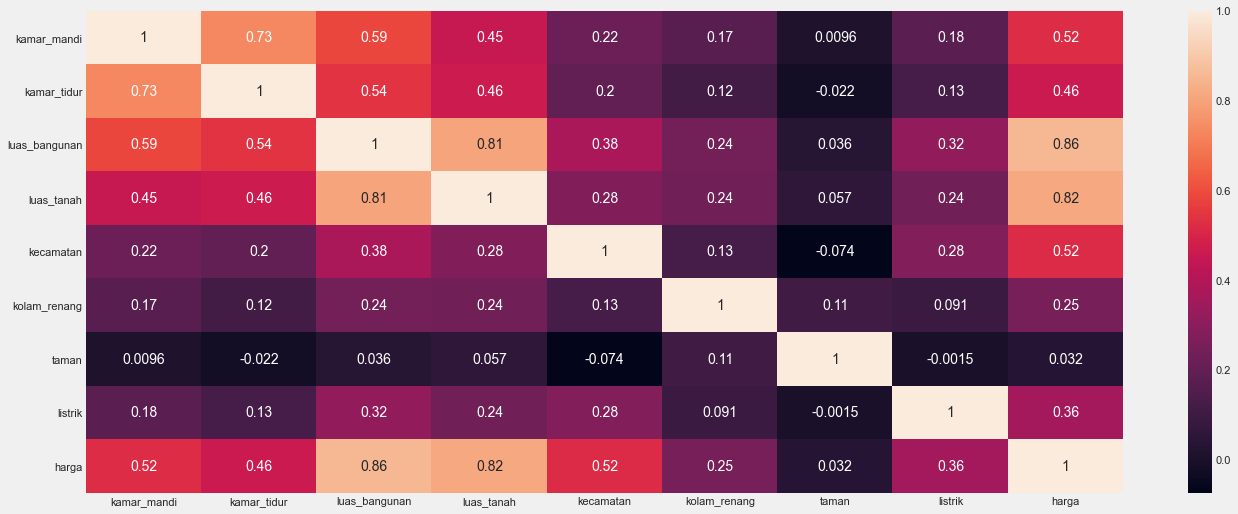

In [39]:
sns.heatmap(initial_data.corr(method = 'spearman'),annot=True)
plt.show()

In [40]:
pd.DataFrame(model.params).reset_index().sort_values(by = 0, ascending = False)

,index,0
3,luas_bangunan,3.802011e-01
4,luas_tanah,2.802679e-01
5,kecamatan,2.752674e-01
6,kolam_renang,9.983061e-02
1,kamar_mandi,6.522312e-02
7,taman,2.090338e-02
8,listrik,1.600078e-02
2,kamar_tidur,1.206087e-02
0,const,-9.714451e-17
